In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from lightgbm import LGBMClassifier

from optuna.samplers import TPESampler
import optuna

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('/kaggle/input/obesity-varadadf/train.csv')
train_data.name = "Train Dataset"
test_data = pd.read_csv('/kaggle/input/obesity-varadadf/test.csv')
sample_submission = pd.read_csv('/kaggle/input/obesity-varadadf/sample_submission.csv')


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [4]:
train_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [5]:
train_data.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
test_data.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [7]:
test_data.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000,13840.000000
mean,27677.500000,23.952740,1.698934,87.384504,2.442898,2.750610,2.032044,0.974532,0.611033
std,3995.408198,5.799814,0.088761,26.111819,0.531606,0.710927,0.611230,0.840361,0.608005
min,20758.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,24217.750000,20.000000,1.631662,65.000000,2.000000,3.000000,1.771781,0.001086,0.000000
50%,27677.500000,22.906342,1.700000,83.952968,2.358087,3.000000,2.000000,1.000000,0.552498
75%,31137.250000,26.000000,1.760710,111.157811,3.000000,3.000000,2.552388,1.571865,1.000000
max,34597.000000,61.000000,1.980000,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


**Visualising null values in dataset**

Text(0.5, 1.0, 'Test Dataset')

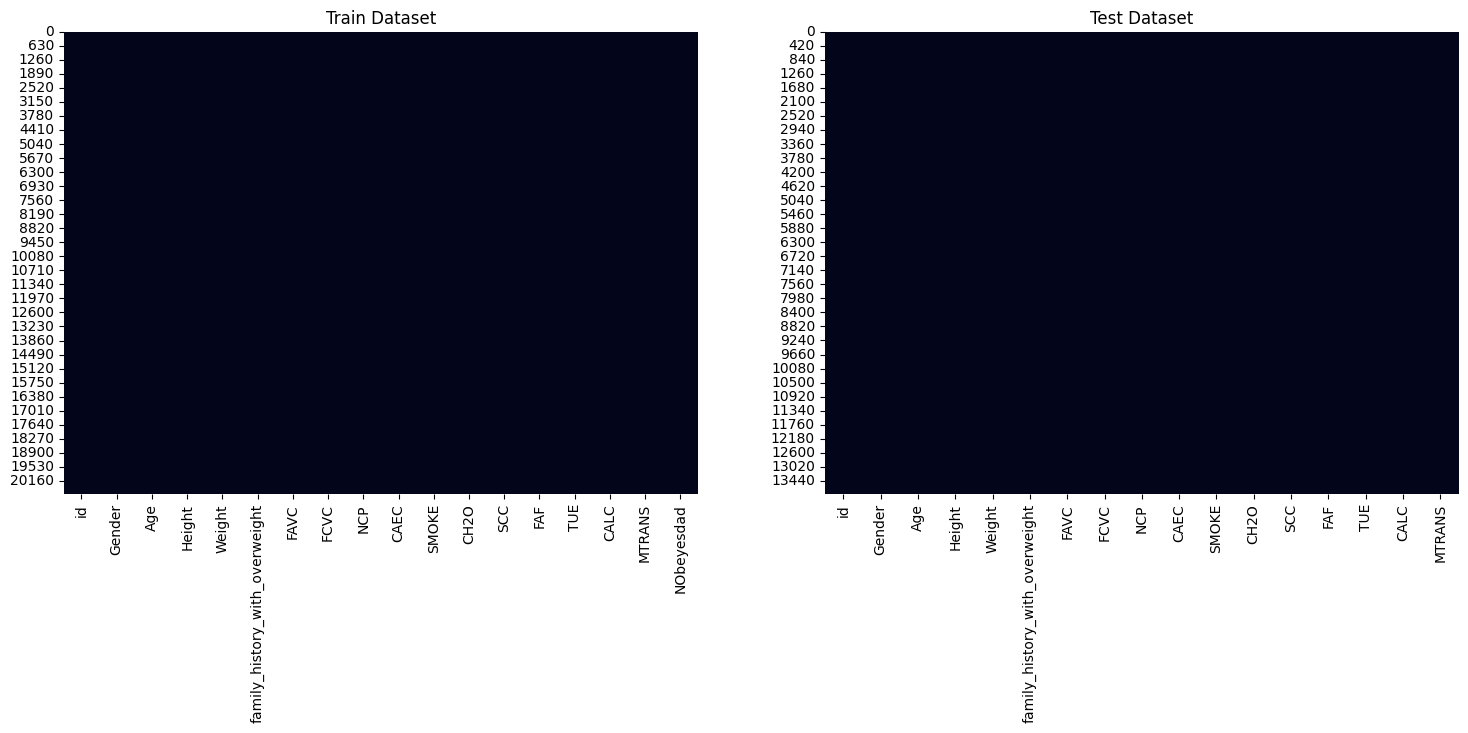

In [ ]:
fig,axis=plt.subplots(1,2,figsize=(18,6))
sns.heatmap(train_data.isna(),  cbar=False, ax=axis[0])
axis[0].set_title('Train Dataset')

# Visualize null values in test dataset
sns.heatmap(test_data.isna(),  cbar=False, ax=axis[1])
axis[1].set_title('Test Dataset')




In [9]:
def get_variable_types(dataframe):
    conti = []
    categor = []

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            categor.append(column)
        else:
            conti.append(column)

    return conti, categor

conti, categor = get_variable_types(train_data)
conti.remove('id'), categor.remove('NObeyesdad')

print("Continuous Variables:", conti)
print("Categorical Variables:", categor)

In [10]:
def plotdist(dataframe,target_column):
    valuecount=dataframe[target_column].value_counts()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    
    sns.barplot(x=valuecount.index,y=valuecount.values,palette='twilight',ax=ax1)
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    
    for index, value in enumerate(valuecount):
        ax1.text(index, value, str(value), ha='center', va='bottom', fontsize=10)
        
    ax2.pie(valuecount, labels=valuecount.index, autopct='%1.1f%%', colors=sns.color_palette("twilight", len(valuecount)))
    ax2.axis('equal')
    fig.suptitle(f'Comparison of {target_column} ', fontsize=18)
    plt.show()

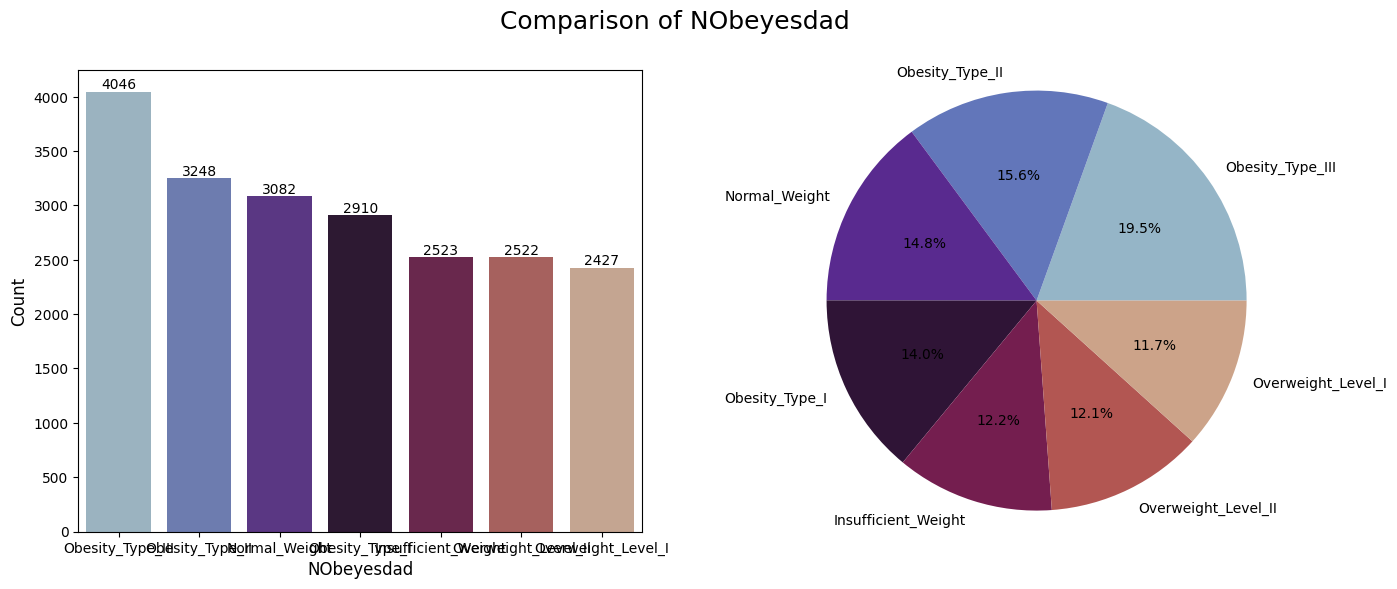

In [11]:
plotdist(train_data, 'NObeyesdad')

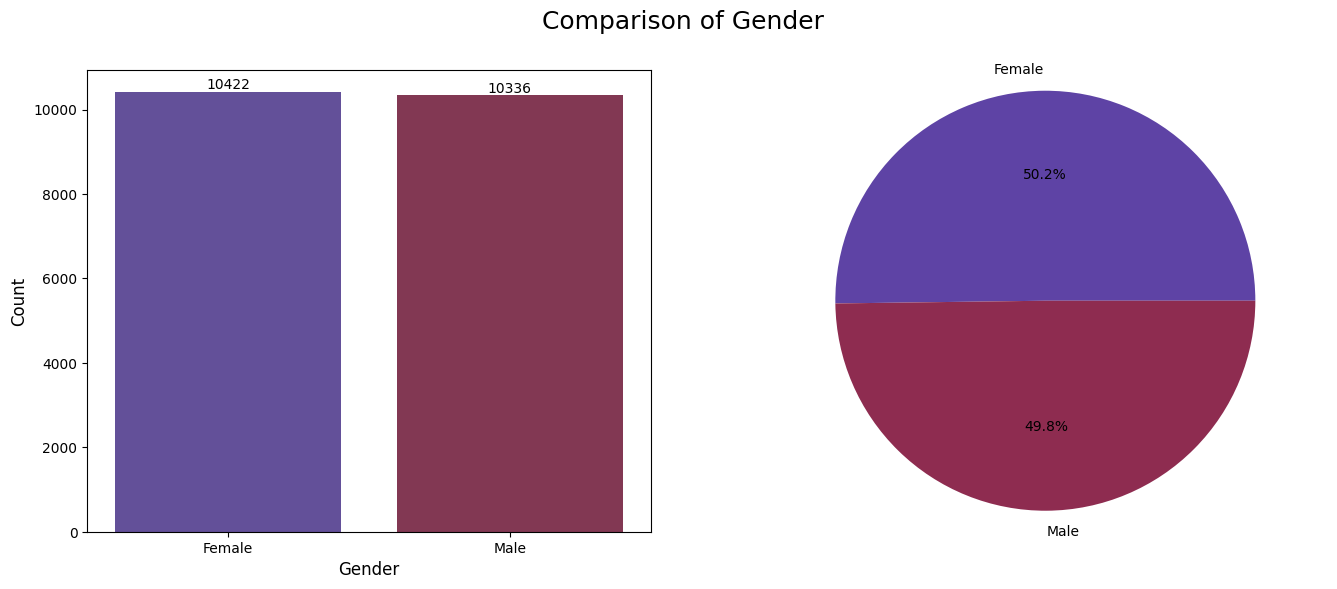

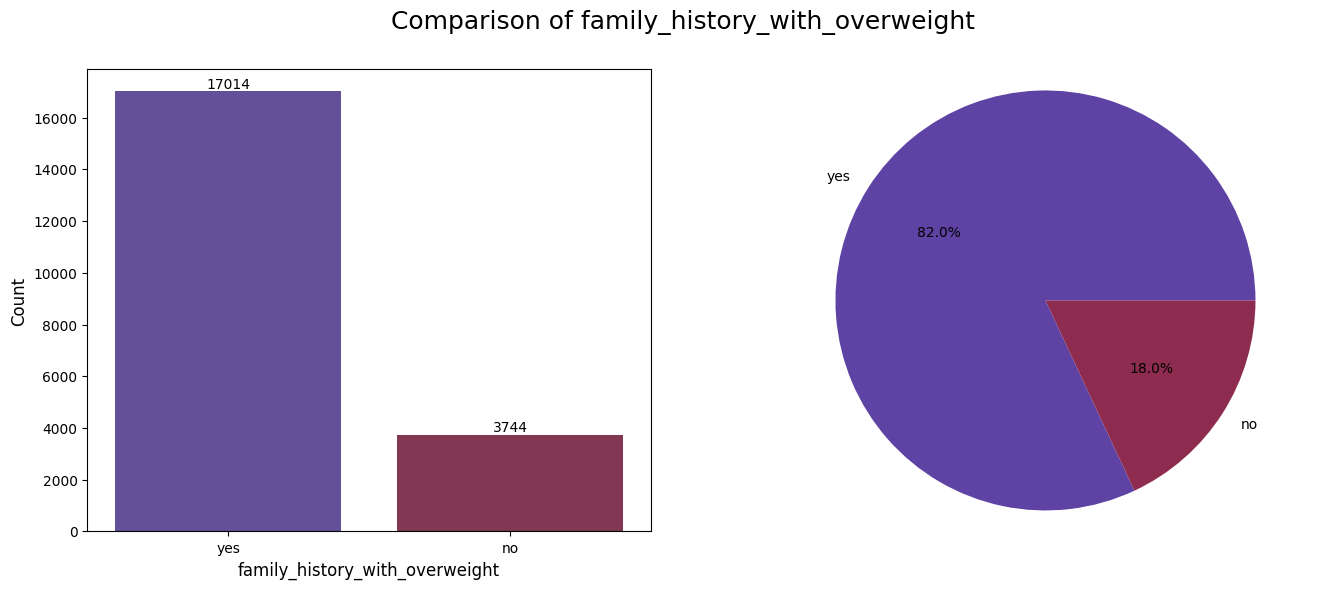

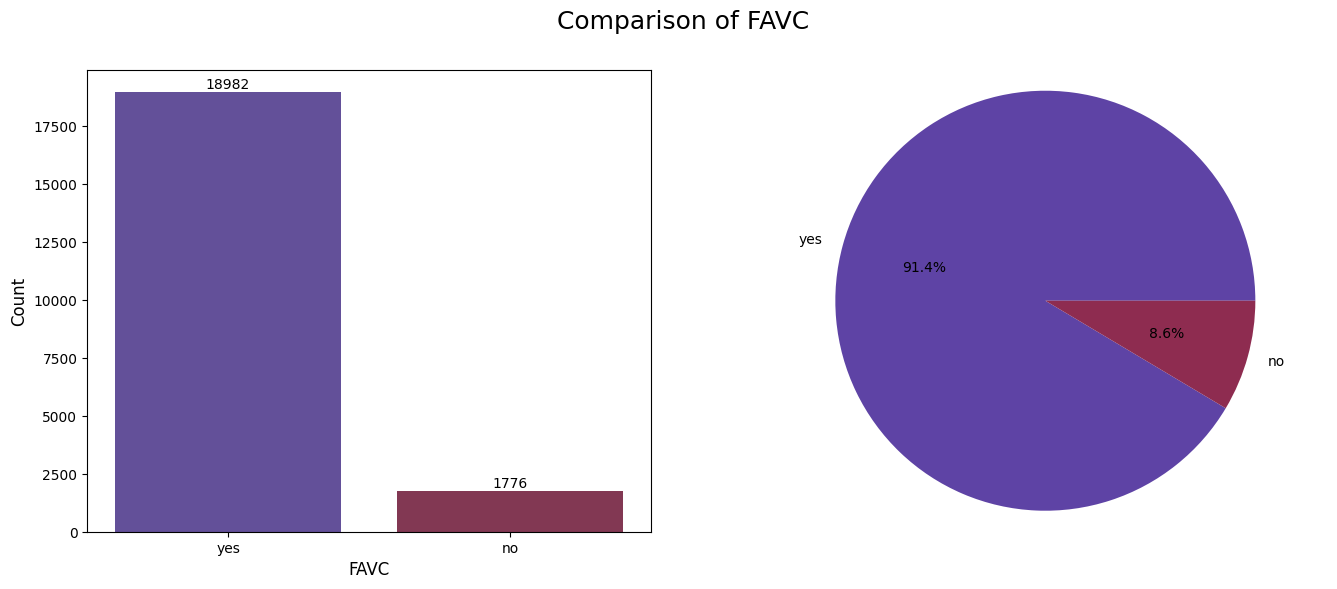

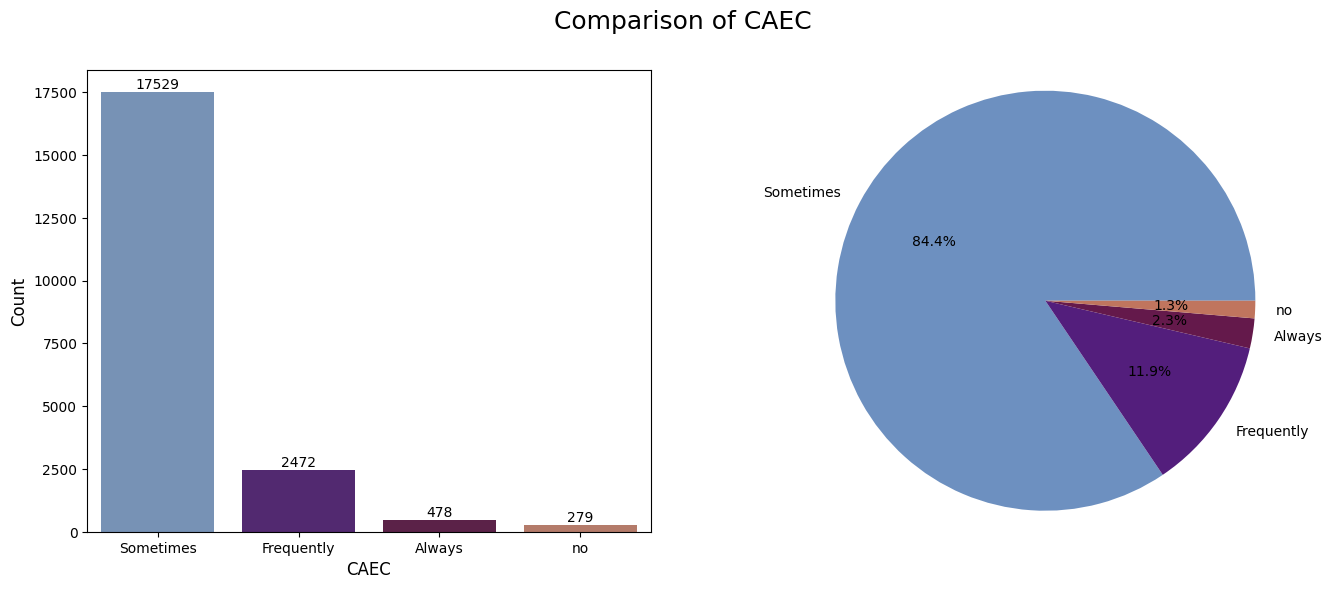

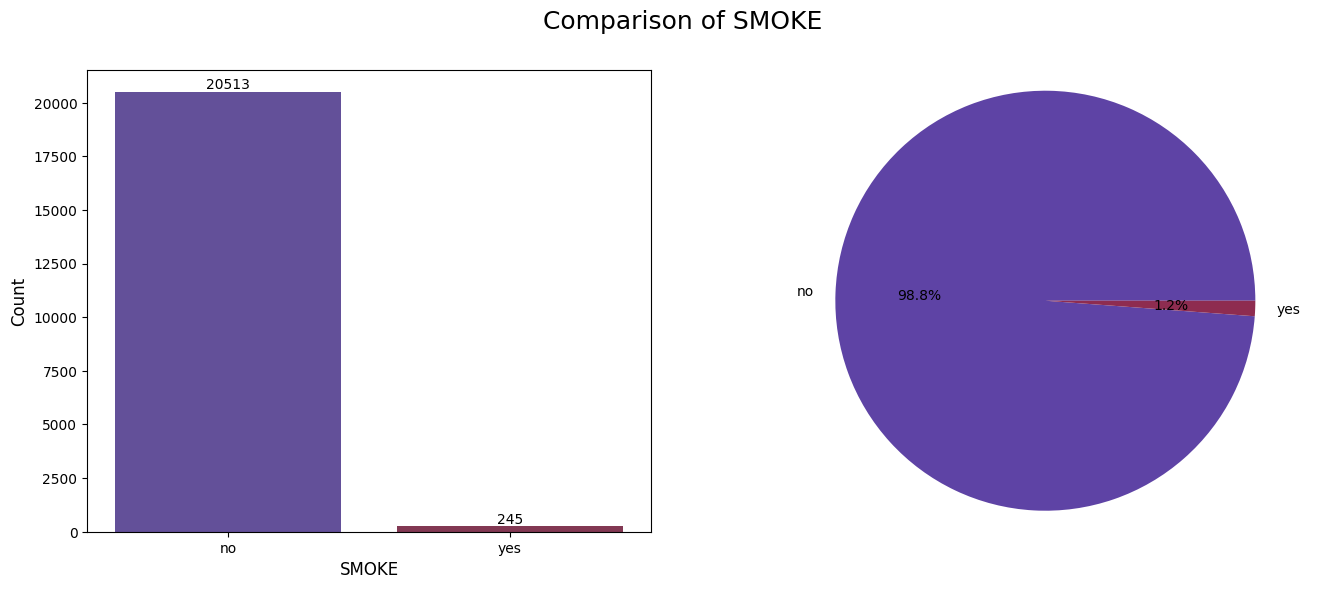

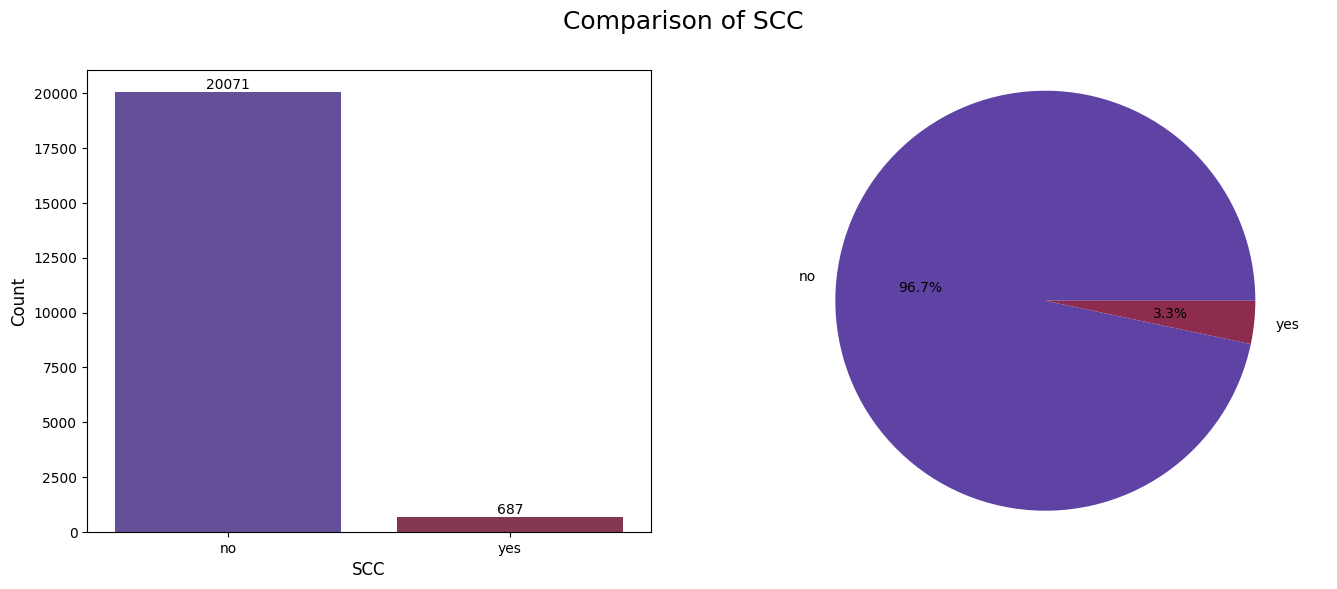

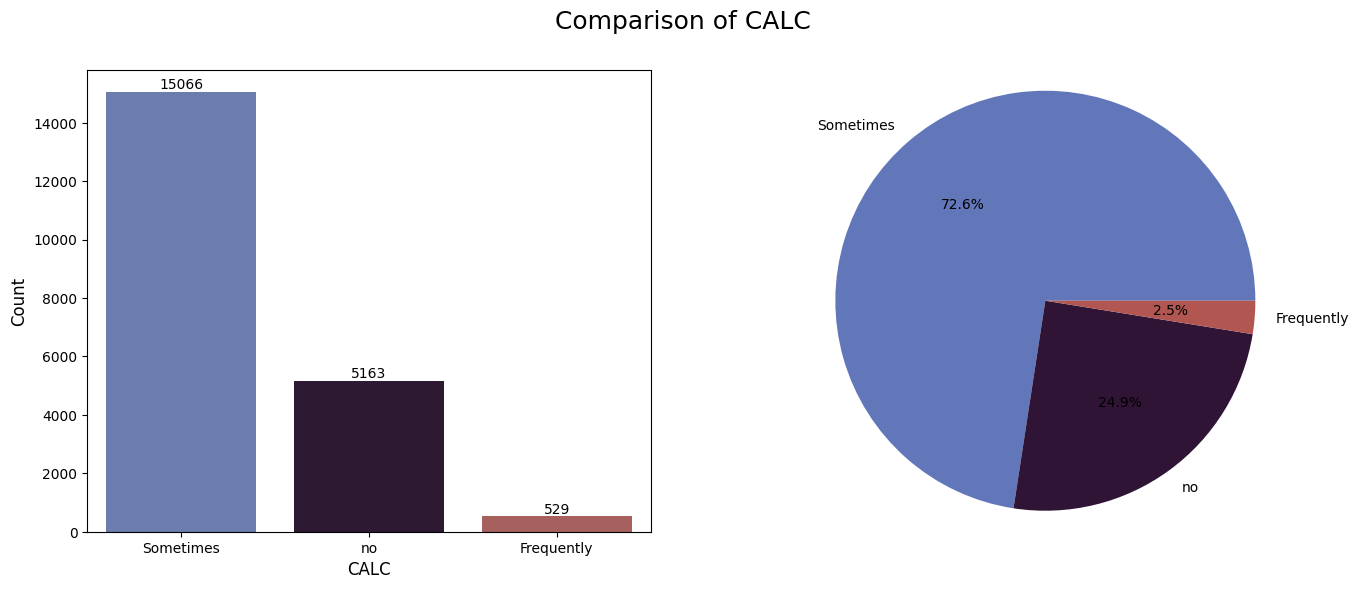

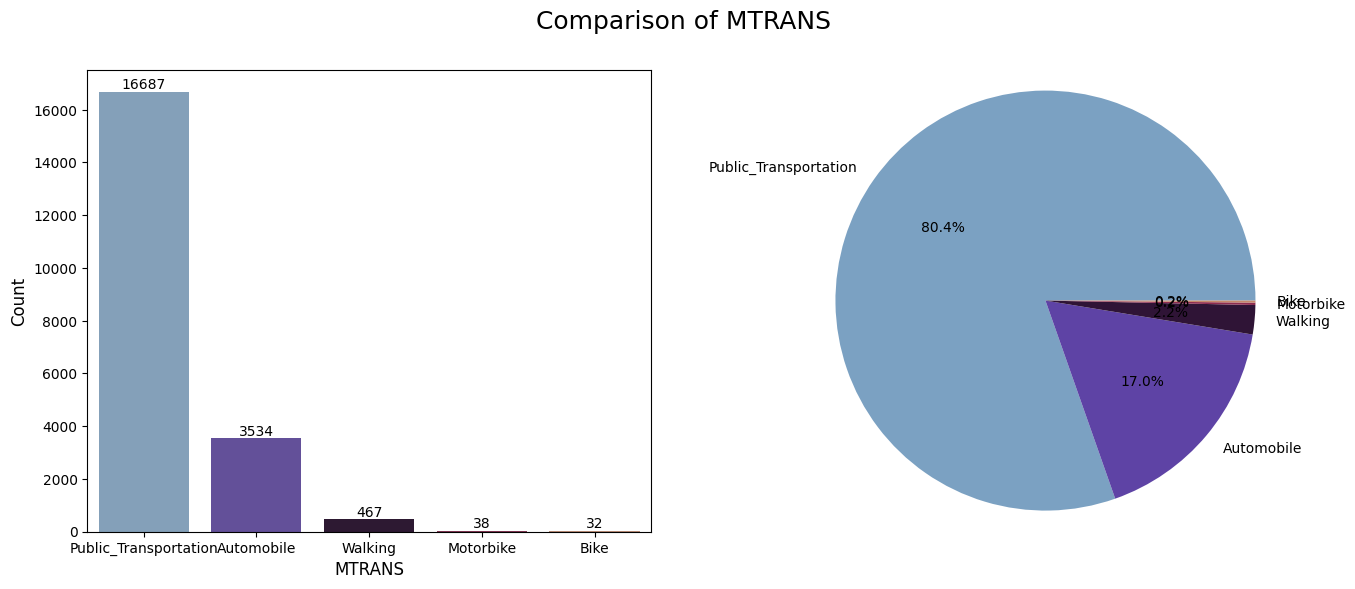

In [12]:
for column in categor:
    plotdist(train_data, column)

In [13]:
test = test_data.drop(['id'], axis=1)

In [14]:
train = pd.get_dummies(train_data,
                       columns=categor)
test = pd.get_dummies(test, 
                      columns=categor)
train.head()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,NObeyesdad,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,Normal_Weight,...,True,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,Insufficient_Weight,...,True,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,Obesity_Type_III,...,True,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,Overweight_Level_II,...,True,False,False,True,False,False,False,False,True,False


In [15]:
X = train.drop(['NObeyesdad'], axis=1)
y = train['NObeyesdad']
X

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,...,SCC_no,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,False,...,True,False,False,True,False,False,False,False,True,False
1,1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,True,...,True,False,False,False,True,True,False,False,False,False
2,2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,True,...,True,False,False,False,True,False,False,False,True,False
3,3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,True,...,True,False,False,True,False,False,False,False,True,False
4,4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,False,...,True,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,False,...,True,False,False,True,False,False,False,False,True,False
20754,20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,False,...,True,False,False,True,False,False,False,False,True,False
20755,20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,False,...,True,False,False,False,True,False,False,False,True,False
20756,20756,33.852953,1.700000,83.520113,2.671238,1.971472,2.144838,0.000000,0.973834,False,...,True,False,False,False,True,True,False,False,False,False


In [16]:
y

0        Overweight_Level_II
1              Normal_Weight
2        Insufficient_Weight
3           Obesity_Type_III
4        Overweight_Level_II
                ...         
20753        Obesity_Type_II
20754    Insufficient_Weight
20755        Obesity_Type_II
20756    Overweight_Level_II
20757        Obesity_Type_II
Name: NObeyesdad, Length: 20758, dtype: object

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (16606, 31)
X_test shape: (4152, 31)
y_train shape: (16606,)
y_test shape: (4152,)


In [18]:
best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

In [19]:
lgbm_classifier = LGBMClassifier(**best_params)

lgbm_classifier.fit(X_train, y_train)

y_pred = lgbm_classifier.predict(X_test)
accuracy_score(y_test, y_pred) 

0.9046242774566474

In [20]:
predictions = lgbm_classifier.predict(test)
predictions

array(['Insufficient_Weight', 'Insufficient_Weight',
       'Insufficient_Weight', ..., 'Insufficient_Weight',
       'Insufficient_Weight', 'Insufficient_Weight'], dtype=object)

In [21]:
sample_submission['NObeyesdad'] = predictions
sample_submission

,id,NObeyesdad
0,20758,Insufficient_Weight
1,20759,Insufficient_Weight
2,20760,Insufficient_Weight
3,20761,Insufficient_Weight
4,20762,Insufficient_Weight
...,...,...
13835,34593,Insufficient_Weight
13836,34594,Insufficient_Weight
13837,34595,Insufficient_Weight
13838,34596,Insufficient_Weight


In [22]:
sample_submission.to_csv('submission.csv', index=False)